In [20]:
import os
import json
import requests
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

import tornado.ioloop
import tornado.web

# Utils

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

#def get_mnist():
mnist_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/lazyprogrammer/data/mnist.csv', header='infer')

if mnist_df.isna().sum().max() == 0:
  print('There is no NA values')
else:
  print(f'There are {mnist_df.isna().sum().max()} NAs' )

mnist_df.head()

Mounted at /content/gdrive/
There is no NA values


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
def plot_misclasified_examples(x, true_lables, predicted_lables, n=5, print_misclassified=False, labels=None):
  misclassified_idx = np.where(predicted_lables != true_lables)[0]
  misclassified_random_idxes = np.random.choice(misclassified_idx, n*n)
  plt.figure(figsize=(15,15))
  for i in range(n*n):
      idx = misclassified_random_idxes[i]
      plt.subplot(n,n,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x[idx], cmap='gray')
      if labels==None:
        plt.xlabel("True  %s, Pred: %s" % (true_lables[idx], predicted_lables[idx]))
      else:
        plt.xlabel("True  %s, Pred: %s" % (labels[true_lables[idx]], labels[predicted_lables[idx]]))
  plt.show()

  if print_misclassified:
      if labels==None:
        print(pd.DataFrame({'idx':misclassified_random_idxes,
                        'true':true_lables[misclassified_random_idxes],
                        'pred':predicted_lables[misclassified_random_idxes]}))
      else:
        print(pd.DataFrame({'idx':misclassified_random_idxes,
                        #'true':labels[true_lables[misclassified_random_idxes]],
                        'true':true_lables[misclassified_random_idxes],
                        #'pred':labels[predicted_lables[misclassified_random_idxes]]}))
                        'pred':predicted_lables[misclassified_random_idxes]}))

def plot_examples(x, y, cmap='gray', labels=None):
  plt.figure(figsize=(15,15))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x[i], cmap=cmap)
      if labels==None:
        plt.xlabel(y[i])
      else:
        plt.xlabel(labels[y[i]])
  plt.show()

In [4]:
def shuffle_pairs(X, Y):
  N = len(X)
  indexes = np.arange(N)
  np.random.shuffle(indexes)
  X = X[indexes]
  Y = Y[indexes]
  return X, Y


def get_mnist_data(should_shuffle = True, should_plot_examples=True):
  mnist_data = mnist_df.copy().values
  if (should_shuffle == True):
    np.random.shuffle(mnist_data)
  Y_mnist = mnist_data[:, 0]
  X_mnist = np.divide(mnist_data[:, 1:], 255.0)
  picture_shape = (28, 28)

  if (should_plot_examples == True):
    plot_examples(X_mnist.reshape((-1, *picture_shape)), Y_mnist, cmap='gray', labels=None)
  return X_mnist, Y_mnist, picture_shape


def get_xor_data(N=200, should_plot_data=True):
    X = np.zeros((N, 2))
    Nq = N // 4
    X[:Nq] = np.random.random((Nq, 2)) / 2 + 0.5 # (0.5-1, 0.5-1)
    X[Nq:(2*Nq)] = np.random.random((Nq, 2)) / 2 # (0-0.5, 0-0.5)
    X[(2*Nq):(3*Nq)] = np.random.random((Nq, 2)) / 2 + np.array([[0, 0.5]]) # (0-0.5, 0.5-1)
    X[(3*Nq):] = np.random.random((Nq, 2)) / 2 + np.array([[0.5, 0]]) # (0.5-1, 0-0.5)
    Y = np.array([0]*(N//2) + [1]*(N//2))

    X, Y = shuffle_pairs(X, Y)

    if (should_plot_data == True):
      plt.figure(figsize=(10,10))
      plt.scatter(X[:,0], X[:,1], c=Y, s=100, alpha=0.5);
      plt.title('Training data plot')
    return X, Y


def get_donut_data(N=200, should_plot_data=True):
    R_inner = 5
    R_outer = 10

    # distance from origin is radius + random normal
    # angle theta is uniformly distributed between (0, 2pi)
    R1 = np.random.randn(N//2) + R_inner
    theta = 2*np.pi*np.random.random(N//2)
    X_inner = np.concatenate([[R1 * np.cos(theta)], [R1 * np.sin(theta)]]).T

    R2 = np.random.randn(N//2) + R_outer
    theta = 2*np.pi*np.random.random(N//2)
    X_outer = np.concatenate([[R2 * np.cos(theta)], [R2 * np.sin(theta)]]).T

    X = np.concatenate([ X_inner, X_outer ])
    Y = np.array([0]*(N//2) + [1]*(N//2))
    
    X, Y = shuffle_pairs(X, Y)

    if (should_plot_data == True):
      plt.figure(figsize=(10,10))
      plt.scatter(X[:,0], X[:,1], c=Y, s=100, alpha=0.5);
      plt.title('Training data plot')
    return X, Y

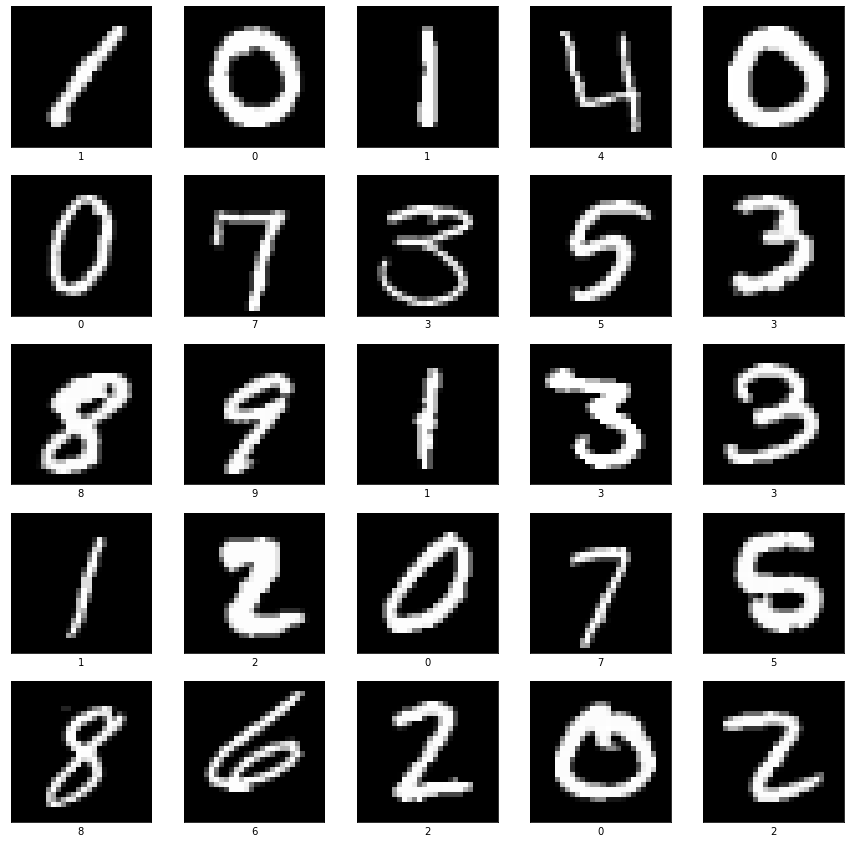

In [12]:
X, Y, _ = get_mnist_data(should_shuffle = False)

# Train model and save it

In [13]:
Ntrain = len(X)//4
Xtrain, Ytrain = X[:Ntrain], Y[:Ntrain]
Xtest, Ytest = X[Ntrain:], Y[Ntrain:]

model = RandomForestClassifier()
model.fit(Xtrain, Ytrain)

print('Test accuracy:', model.score(Xtest, Ytest))


with open('mnist_model.pkl', 'wb') as f:
    pickle.dump(model, f)

! ls

Test accuracy: 0.9492698412698413
gdrive	mnist_model.pkl  sample_data


# Load model and host it inside a service

In [21]:
class MainHandler(tornado.web.RequestHandler):
    def get(self):
        self.write("Hello, Tornado!")


class PredictionHandler(tornado.web.RequestHandler):
    # predict one sample at a time
    def post(self):
        print('body:', {self.request.body})
        print('arguments:', {self.request.arguments})
        # will look like this:
        # body: three=four&one=two
        # arguments: {'three': ['four'], 'one': ['two']}
        params = self.request.arguments
        x = np.array(list(map(float, params['input'])))
        y = model.predict([x])[0]
        self.write(json.dumps({'prediction': y.item()}))
        self.finish()

In [24]:
if not os.path.exists('mnist_model.pkl'):
    exit("Can't run without the model!")

with open('mnist_model.pkl', 'rb') as f:
    model = pickle.load(f)
    print('Model mnist_model.pkl loaded')

Model mnist_model.pkl loaded


In [26]:
application = tornado.web.Application([(r"/", MainHandler), (r"/predict", PredictionHandler)])
application.listen(8889)
tornado.ioloop.IOLoop.current().start()

RuntimeError: ignored

# Run caller

In [27]:
N = len(X)
while True:
  i = np.random.choice(N)
  responce = requests.post('http://localhost:8889/predict', data={'input':X[i]})
  responce_as_json = responce.json()
  print('Prediction service response:', responce_as_json)
  print('Target:', Y[i])

  plt.figure(figsize=(10,10))
  plt.imshow(X[i].reshape(28, 28), cmap='gray')
  plt.show()

  sign = raw_imput('Continue y/n?')
  if (sign in ('n', 'N')):
    break

KeyboardInterrupt: ignored